In [1]:
import numpy as np
import pandas as pd
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")

np.random.seed(42)
trip_duration = np.concatenate(
    [
        np.random.gamma(shape=3, scale=8, size=950),
        np.random.uniform(low=120, high=300, size=50),
    ]
)
trip_data = pd.DataFrame({"duration": trip_duration})

In [2]:
def builtin_stats(data: pd.Series):
    return {
        "mean": data.mean(),
        "median": data.median(),
        "mode": data.round(1).mode()[0],
        "range": data.max() - data.min(),
        "variance": data.var(ddof=1),
        "std": data.std(ddof=1),
        "cv": data.std(ddof=1) / data.mean() * 100,
        "skewness": data.skew(),
        "kurtosis": data.kurtosis(),
        "q25": data.quantile(0.25),
        "q50": data.quantile(0.5),
        "q75": data.quantile(0.75),
        "iqr": data.quantile(0.75) - data.quantile(0.25),
    }

def quantile(sorted_x, n, p):
        h = p * (n + 1)

        if h <= 1:
            return sorted_x[0]
        if h >= n:
            return sorted_x[-1]

        k = int(h)
        d = h - k

        return sorted_x[k - 1] + d * (sorted_x[k] - sorted_x[k - 1])

def manual_stats(data: pd.Series):
    n = len(data)
    sorted_data = np.sort(data)

    mean: float = data.sum() / n

    median = quantile(sorted_data, n, 0.5)

    mode = np.unique(np.round(data, 1), return_counts=True)
    mode = mode[0][np.argmax(mode[1])]

    data_range = data.max() - data.min()
    
    variance = ((data - mean) ** 2).sum() / (n - 1)
    std = np.sqrt(variance)
    cv = std / mean * 100

    m3 = ((data - mean) ** 3).sum() / (n - 1)
    skewness = (m3 / (std**3)) * np.sqrt(n * (n - 1)) / (n - 2)

    m4 = ((data - mean) ** 4).sum() / (n - 1)
    kurtosis = m4 / (std**4) - 3
    kurtosis = ((n - 1) * ((n + 1) * kurtosis + 6)) / ((n - 2) * (n - 3))

    q25, q75 = quantile(sorted_data, n, 0.25), quantile(sorted_data, n, 0.75)
    iqr = q75 - q25

    return {
        "mean": mean,
        "median": median,
        "mode": mode,
        "range": data_range,
        "variance": variance,
        "std": std,
        "cv": cv,
        "skewness": skewness,
        "kurtosis": kurtosis,
        "q25": q25,
        "q50": median,
        "q75": q75,
        "iqr": iqr,
    }

In [3]:
stats_builtin = builtin_stats(trip_data["duration"])
stats_manual = manual_stats(trip_data["duration"])

comparison = pd.DataFrame([stats_builtin, stats_manual], index=["Встроенные", "Своими лапками"])
print("Сравнение результатов встроенных и ручных методов:")
display(comparison)

Сравнение результатов встроенных и ручных методов:


,mean,median,mode,range,variance,std,cv,skewness,kurtosis,q25,q50,q75,iqr
Встроенные,34.083614,22.423373,24.0,295.412339,2079.752785,45.604307,133.801263,3.986261,16.428019,14.701237,22.423373,33.956648,19.255411
Своими лапками,34.083614,22.423373,24.0,295.412339,2079.752785,45.604307,133.801263,3.984268,16.408582,14.688394,22.423373,33.975020,19.286626


In [4]:
def detect_outliers_iqr(data, factor=1.5):
    q1, q3 = np.percentile(data, [25, 75])
    iqr = q3 - q1
    lower = q1 - factor * iqr
    upper = q3 + factor * iqr
    return data[(data < lower) | (data > upper)]


outliers = detect_outliers_iqr(trip_data["duration"])
trip_no_outliers = trip_data[~trip_data["duration"].isin(outliers)]

stats_no_outliers = builtin_stats(trip_no_outliers["duration"])

In [5]:

stats_comparison = pd.DataFrame(
    [stats_manual, stats_no_outliers], index=["С выбросами", "Без выбросов"]
)
print("Сравнение статистических характеристик с и без выбросов:")
display(stats_comparison)


Сравнение статистических характеристик с и без выбросов:


,mean,median,mode,range,variance,std,cv,skewness,kurtosis,q25,q50,q75,iqr
С выбросами,34.083614,22.423373,24.0,295.412339,2079.752785,45.604307,133.801263,3.984268,16.408582,14.688394,22.423373,33.975020,19.286626
Без выбросов,23.734302,21.608904,24.0,61.974073,157.897146,12.565713,52.943260,0.759747,0.095740,14.293860,21.608904,30.723239,16.429379


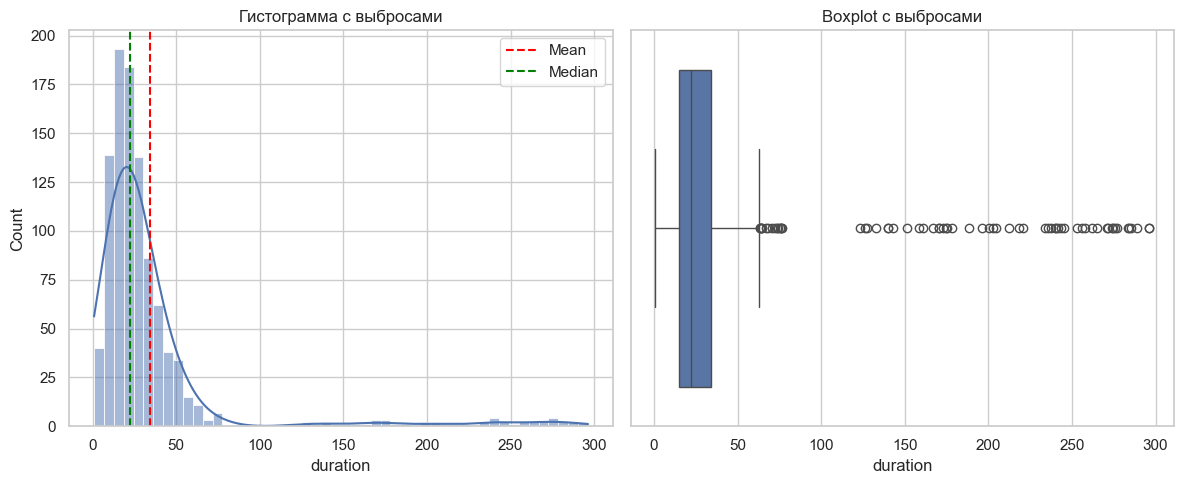

In [6]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.histplot(trip_data["duration"], bins=50, kde=True)
plt.axvline(stats_builtin["mean"], color="red", linestyle="--", label="Mean")
plt.axvline(stats_builtin["median"], color="green", linestyle="--", label="Median")
plt.title("Гистограмма с выбросами")
plt.legend()

plt.subplot(1, 2, 2)
sns.boxplot(x=trip_data["duration"])
plt.title("Boxplot с выбросами")

plt.tight_layout()
plt.show()

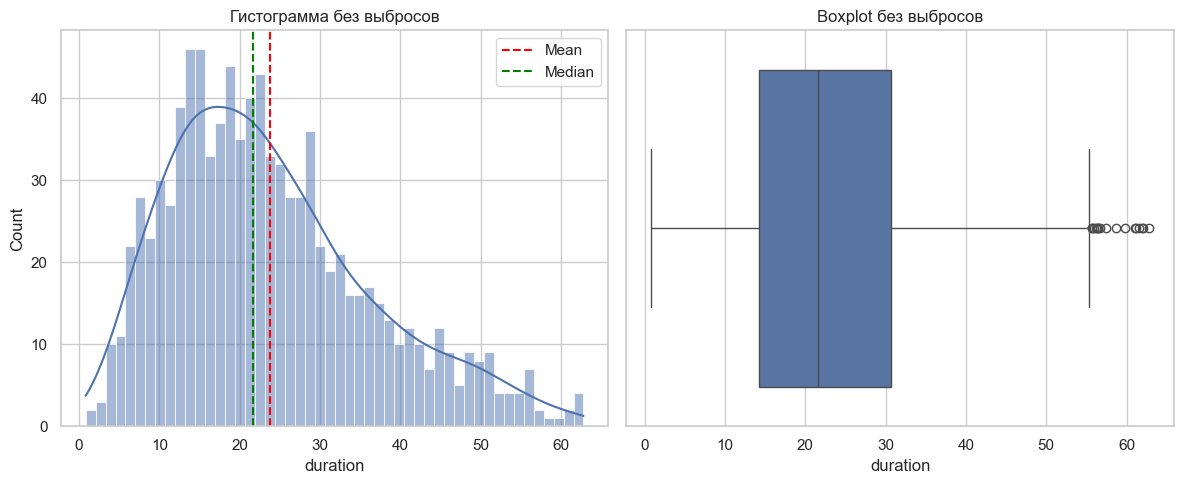

In [7]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.histplot(trip_no_outliers["duration"], bins=50, kde=True)
plt.axvline(stats_no_outliers["mean"], color="red", linestyle="--", label="Mean")
plt.axvline(stats_no_outliers["median"], color="green", linestyle="--", label="Median")
plt.title("Гистограмма без выбросов")
plt.legend()

plt.subplot(1, 2, 2)
sns.boxplot(x=trip_no_outliers["duration"])
plt.title("Boxplot без выбросов")

plt.tight_layout()
plt.show()

In [8]:
print("\nИнтерпретация формы распределения:")
print(f"Среднее = {stats_manual['mean']:.2f}, Медиана = {stats_manual['median']:.2f}")
print("Среднее > медиана → распределение правосторонне асимметрично")
print(
    f"Асимметрия = {stats_manual['skewness']:.2f}, Эксцесс = {stats_manual['kurtosis']:.2f}"
)
print(
    "Положительная асимметрия и положительный эксцесс → длинный хвост справа, острое распределение"
)
print(
    "Тип распределения: правостороннее с выбросами (основная масса + длинные поездки)"
)

with PdfPages("trip_duration_report.pdf") as pdf:
    plt.figure(figsize=(10, 6))
    plt.axis("off")
    stats_manual_str = pd.DataFrame([stats_manual]).to_string(line_width=100)
    plt.text(
        0,
        1,
        "Сводная таблица: Статистические характеристики продолжительности поездок",
        fontsize=12,
        va="top",
    )
    plt.text(0, 0.95, stats_manual_str, fontsize=10, va="top", family="monospace")
    pdf.savefig()
    plt.close()

    plt.figure(figsize=(8, 6))
    sns.histplot(trip_data["duration"], kde=True, bins=30, color="skyblue")
    plt.title("Гистограмма и KDE распределения продолжительности поездок")
    plt.xlabel("Продолжительность поездки (мин)")
    plt.ylabel("Частота")
    pdf.savefig()
    plt.close()

    plt.figure(figsize=(8, 4))
    sns.boxplot(x=trip_data["duration"], color="lightgreen")
    plt.title("Boxplot распределения продолжительности поездок")
    plt.xlabel("Продолжительность поездки (мин)")
    pdf.savefig()
    plt.close()

    plt.figure(figsize=(10, 6))
    plt.axis("off")
    conclusions = [
        "Выводы о распределении продолжительности поездок:",
        "- Среднее > медианы → распределение скошено вправо",
        "- Присутствуют выбросы, влияющие на среднее и дисперсию",
        "- Boxplot показывает несколько экстремально длинных поездок",
        "- Коэффициент асимметрии положительный, эксцесс > 0 → тяжелый правый хвост",
        "",
        "Рекомендации для прогнозирования времени поездок:",
        "- Использовать медиану или усеченное среднее для предсказаний",
        "- Рассматривать удаление или корректировку выбросов",
        "- Особое внимание уделять длинным поездкам при моделировании",
        "",
        "Наиболее информативные характеристики:",
        "- Медиана, межквартильный размах, коэффициент вариации и асимметрия",
        "- Эти показатели лучше отражают распределение с выбросами и скошенность",
    ]

    for i, line in enumerate(conclusions):
        plt.text(0, 1 - i * 0.08, line, fontsize=12, va="top")

    pdf.savefig()
    plt.close()


Интерпретация формы распределения:
Среднее = 34.08, Медиана = 22.42
Среднее > медиана → распределение правосторонне асимметрично
Асимметрия = 3.98, Эксцесс = 16.41
Положительная асимметрия и положительный эксцесс → длинный хвост справа, острое распределение
Тип распределения: правостороннее с выбросами (основная масса + длинные поездки)


---

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import fetch_california_housing
from IPython.display import display

california = fetch_california_housing()
housing_data = pd.DataFrame(california.data, columns=california.feature_names)
housing_data["MedHouseVal"] = california.target

print("Структура данных:")
housing_data.info()

print("\nПервые 5 строк данных:")
display(housing_data.head())

print("\nПроверка пропущенных значений:")

missing_counts = housing_data.isnull().sum()
missing_percent = housing_data.isnull().mean() * 100
missings = pd.DataFrame(
    data=[missing_counts, missing_percent],
    index=["Количество пропусков", "Процент пропусков"],
).T
display(missings)

Структура данных:
<class 'pandas.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   MedInc       20640 non-null  float64
 1   HouseAge     20640 non-null  float64
 2   AveRooms     20640 non-null  float64
 3   AveBedrms    20640 non-null  float64
 4   Population   20640 non-null  float64
 5   AveOccup     20640 non-null  float64
 6   Latitude     20640 non-null  float64
 7   Longitude    20640 non-null  float64
 8   MedHouseVal  20640 non-null  float64
dtypes: float64(9)
memory usage: 1.4 MB

Первые 5 строк данных:


,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422



Проверка пропущенных значений:


,Количество пропусков,Процент пропусков
MedInc,0.0,0.0
HouseAge,0.0,0.0
AveRooms,0.0,0.0
AveBedrms,0.0,0.0
Population,0.0,0.0
AveOccup,0.0,0.0
Latitude,0.0,0.0
Longitude,0.0,0.0
MedHouseVal,0.0,0.0


In [ ]:
features = ["MedInc", "HouseAge", "AveRooms", "MedHouseVal"]

stats_table = pd.DataFrame(
    index=features,
    columns=[
        "mean",
        "median",
        "mode",
        "range",
        "variance",
        "std",
        "cv",
        "skewness",
        "kurtosis",
        "q25",
        "q50",
        "q75",
        "iqr",
    ],
)

for col in features:
    data = housing_data[col]
    stats_table.loc[col] = builtin_stats(data)

print("\nСводная таблица статистических характеристик:")
display(stats_table.round(3))


Сводная таблица статистических характеристик:


,mean,median,mode,range,variance,std,cv,skewness,kurtosis,q25,q50,q75,iqr
MedInc,3.870671,3.5348,3.2,14.5002,3.609323,1.899822,49.08249,1.646657,4.952524,2.5634,3.5348,4.74325,2.17985
HouseAge,28.639486,29.0,52.0,51.0,158.39626,12.585558,43.944774,0.060331,-0.800629,18.0,29.0,37.0,19.0
AveRooms,5.429,5.229129,5.1,141.062937,6.121533,2.474173,45.573278,20.697869,879.353264,4.440716,5.229129,6.052381,1.611665
MedHouseVal,2.068558,1.797,1.6,4.85002,1.331615,1.153956,55.785531,0.977763,0.32787,1.196,1.797,2.64725,1.45125


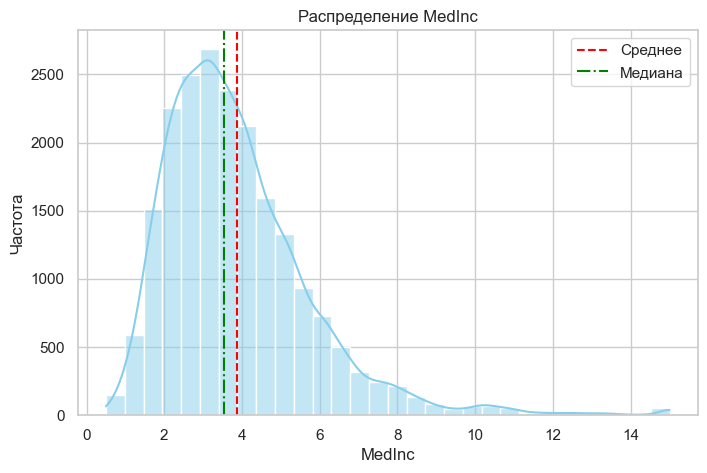

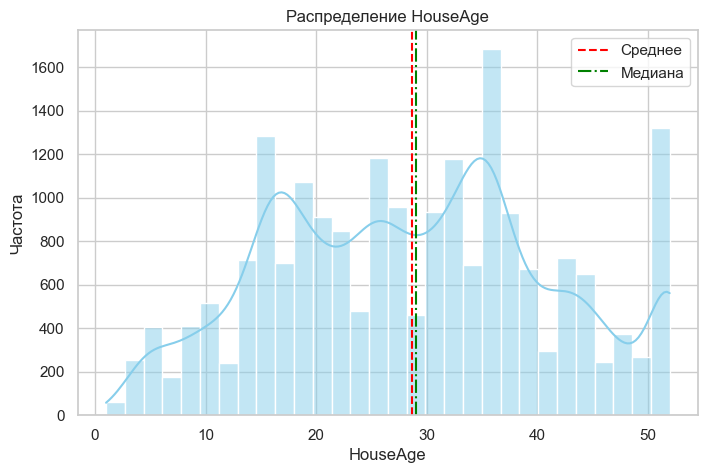

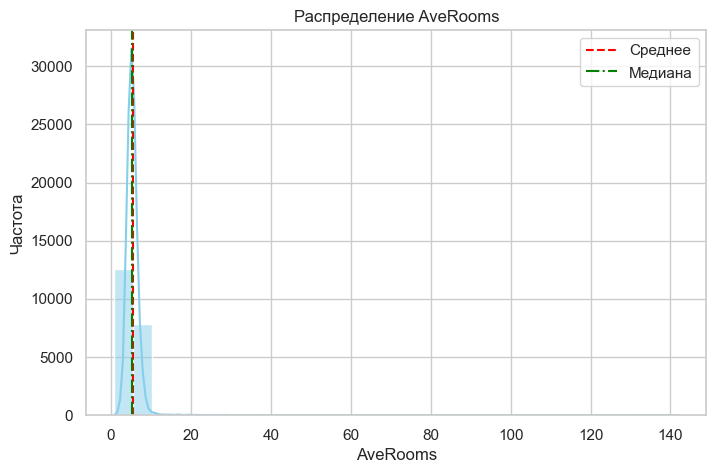

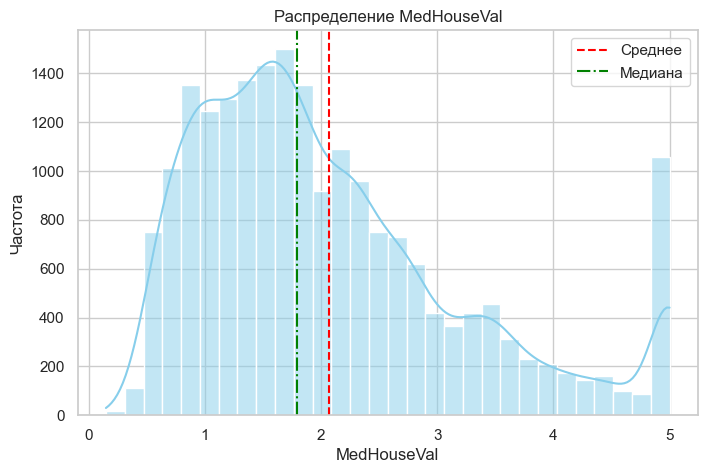

In [12]:
for col in features:
    plt.figure(figsize=(8, 5))
    sns.histplot(housing_data[col], bins=30, kde=True, color="skyblue")
    plt.axvline(housing_data[col].mean(), color="red", linestyle="--", label="Среднее")
    plt.axvline(
        housing_data[col].median(), color="green", linestyle="-.", label="Медиана"
    )
    plt.title(f"Распределение {col}")
    plt.xlabel(col)
    plt.ylabel("Частота")
    plt.legend()
    plt.show()

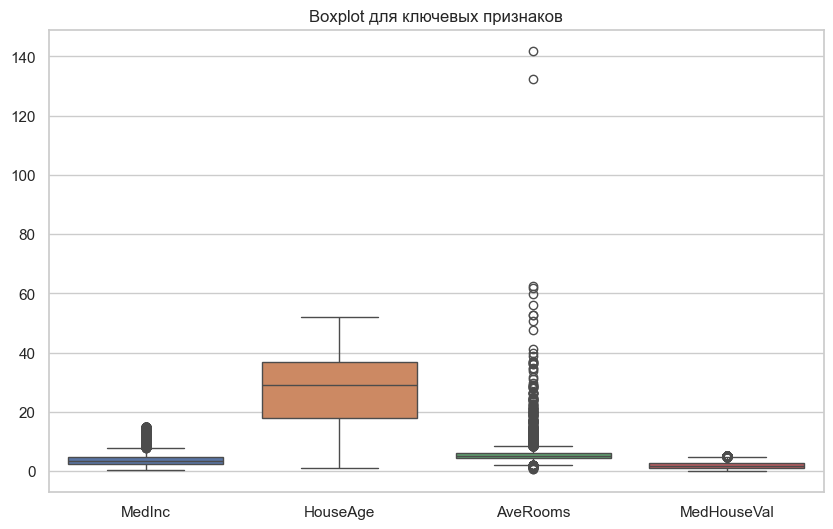

In [13]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=housing_data[features])
plt.title("Boxplot для ключевых признаков")
plt.show()

In [14]:
variation_table = stats_table[["std", "cv", "skewness", "kurtosis"]]
print("\nОценка вариации и формы распределения:")
display(variation_table.round(3))


Оценка вариации и формы распределения:


,std,cv,skewness,kurtosis
MedInc,1.899822,49.08249,1.646657,4.952524
HouseAge,12.585558,43.944774,0.060331,-0.800629
AveRooms,2.474173,45.573278,20.697869,879.353264
MedHouseVal,1.153956,55.785531,0.977763,0.32787


In [15]:
mean_median_ratio = stats_table["mean"] / stats_table["median"]
print("\nСоотношение среднего к медиане:")
display(mean_median_ratio.round(3).to_frame())


Соотношение среднего к медиане:


,0
MedInc,1.095
HouseAge,0.988
AveRooms,1.038
MedHouseVal,1.151


In [16]:
print("\nИнтерпретация формы распределения:")
for col in features:
    mean_val = stats_table.loc[col, "mean"]
    median_val = stats_table.loc[col, "median"]
    skewness_val = stats_table.loc[col, "skewness"]
    print(f"- {col}:")
    if mean_val > median_val:
        print("  Распределение скошено вправо (positive skew).")
    elif mean_val < median_val:
        print("  Распределение скошено влево (negative skew).")
    else:
        print("  Распределение близко к симметричному.")
    print(f"  Коэффициент асимметрии: {skewness_val:.3f}")
    if skewness_val > 1:
        print("  Сильная положительная асимметрия.")
    elif skewness_val < -1:
        print("  Сильная отрицательная асимметрия.")
    else:
        print("  Умеренная или слабая асимметрия.")
    print()


Интерпретация формы распределения:
- MedInc:
  Распределение скошено вправо (positive skew).
  Коэффициент асимметрии: 1.647
  Сильная положительная асимметрия.

- HouseAge:
  Распределение скошено влево (negative skew).
  Коэффициент асимметрии: 0.060
  Умеренная или слабая асимметрия.

- AveRooms:
  Распределение скошено вправо (positive skew).
  Коэффициент асимметрии: 20.698
  Сильная положительная асимметрия.

- MedHouseVal:
  Распределение скошено вправо (positive skew).
  Коэффициент асимметрии: 0.978
  Умеренная или слабая асимметрия.

